# Learn CPTs of Bayesian Netork

For the design of Bayesian Networks for a given problem domain, one can follow one of the following approaches:

1. topology (nodes and arcs) and the conditional propabilities are configured by applying expert knowledge, i.e. experts determine the relevant variables, their dependencies and estimate the conditional probabilities 

2. topology is determined by experts, but the conditional probabilities of the CPTs are learned from data

3. topology and conditional probabilities are learned from data


In this section it is shown how [pyAgrum](https://pyagrum.readthedocs.io/en/0.16.3/index.html) can be applied for the second option, i.e. to learn the Conditional Probability Tables (CPTs) of Bayesian Networks, whose topology is known. 

As demonstrated for example in [learn Bayesian Network from covid-19 data](https://github.com/AlvaroCorrales/BayesianNetworks/blob/main/Bayesian_Networks_Tutorial_covid-19.ipynb) pyAgrum can also applied for option 3, where the topology and the CPTs are learned from data.

In contrast to Machine Learning algorithms, **Bayesian Networks provide the important capability to integrate knowledge from data with expert knowledge.**

In order to demonstrate the learning capability we apply two Bayesian Networks. Both have the identical topology, but they are initialized with different random CPTs. Since a Bayesian Network represents a joint probability distribution (JPT), data can be generated from this network by sampling according to the networks JPT. We sample 10000 instances from one network and apply this data to learn the CPTs of the other. By comparing the distance between the JPTs before and after the second network has been trained with the data from the first network, one can verify, that the second network learns to get similar to the first network, by learning from the first networks data.  


In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Loading two BNs

Two identical Bayes Nets for the *Visit to Asia?*-problem (see section [Bayesian Networks with pyAgrum](BayesNetAsia.ipynb) are loaded from disk.

In [2]:
bn=gum.loadBN(os.path.join("out","VisitAsia.bif"))
bn2=gum.loadBN(os.path.join("out","VisitAsia.bif"))

gnb.sideBySide(bn,bn2,
               captions=['First bn','Second bn'])

First bn,Second bn


As shown below, both BNs have the same CPTs

In [3]:
gnb.sideBySide(bn.cpt("D"),bn2.cpt("D"),
               captions=['CPT Dyspnoae bn','CPT Dyspnoae bn2'])

## Randomizing the parameters

Next, for both BNs the values of the CPTs are randomized

In [4]:
bn.generateCPTs()
bn2.generateCPTs()

As can be seen below, the CPTs of both BNs now have new and different values:

In [5]:
gnb.sideBySide(bn.cpt("D"),bn2.cpt("D"),
               captions=['CPT Dyspnoae bn','CPT Dyspnoae bn2'])

In [6]:
gnb.sideBySide(bn.cpt("L"),bn2.cpt("L"),
               captions=['CPT Lung Cancer bn','CPT Lung Cancer bn2'])

## Exact KL-divergence 

A Bayesian Network represents a joint probability distribution (JPT). For measuring the  similarity of two probability distributions, different metrics exist. Here, we apply the [Kullback-Leibler (KL) Divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence). The lower the KL-divergence, the higher the similarity of the two distributions.   

In [7]:
g1=gum.ExactBNdistance(bn,bn2)
before_learning=g1.compute()
print(before_learning['klPQ'])

3.8997093287973037


Just to be sure that the distance between a BN and itself is 0 :

In [8]:
g0=gum.ExactBNdistance(bn,bn)
print(g0.compute()['klPQ'])

0.0


As shown below, the `compute()`-method of class `ExactBNdistance()`, does not only provide the Kullback-Leibler Divergence, but also other distance measures. However, here we just apply KL.

In [9]:
before_learning

{'klPQ': 3.8997093287973037,
 'errorPQ': 0,
 'klQP': 3.998023350227729,
 'errorQP': 0,
 'hellinger': 1.0224638569378504,
 'bhattacharya': 0.7396439322927275,
 'jensen-shannon': 0.6288012627037836}

## Generate a data from the original BN

By applying the methode `generateCSV()` one can sample data from a Bayesian Network. In the code-cell below 10000 samples, each describing the values of the 8 random variables for one fictional patient, are generated and saved in `out/test.csv`.

In [10]:
gum.generateCSV(bn,os.path.join("out","test.csv"),10000,False)

-64330.74200746451

## Learn CPTs of Bayesian Network from Data

Next, we will apply the data, as sampled from Bayesian Network `bn` above, to learn the CPTs of another Bayesian Network `bnx` with the same topology as `bn`. We expect, that after a successfull learning process, the KL-Divergence between `bn` and `bn2` is low, i.e. both nets are similar.

There exist different options to learn the CPTs of a Bayesian Network. Below, we implement the following 3 options: 

1. the `BNLearner()`-class from pyAgrum
2. the `BNLearner()`-class from pyAgrum with Laplace Smoothing
3. the [pandas crosstab() method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.crosstab.html) for calculating CPTs


### Apply pyAgrum Learners

**BNLearner() without smoothing:**

In [11]:
learner=gum.BNLearner(os.path.join("out","test.csv"),bn) 
bn3=learner.learnParameters(bn.dag())

**BNLearner() without Laplace Smoothing:**

In [12]:
learner=gum.BNLearner(os.path.join("out","test.csv"),bn) 
learner.useAprioriSmoothing(100) # a count C is replaced by C+100
bn4=learner.learnParameters(bn.dag())

As shown below, both approaches learn Bayesian Networks, which have a small KL-divergence to the Bayesian Network, from which training data has been sampled:

In [13]:
after_pyAgrum_learning=gum.ExactBNdistance(bn,bn3).compute()
after_pyAgrum_learning_with_laplace=gum.ExactBNdistance(bn,bn4).compute()
print("KL-Divergence for option without smoothing :{}".format(after_pyAgrum_learning['klPQ']))
print("KL-Divergence for option with smooting(100):{}".format(after_pyAgrum_learning_with_laplace['klPQ']))

KL-Divergence for option without smoothing :0.0008320831554976575
KL-Divergence for option with smooting(100):0.013701987248860887


### Apply pandas to learn CPTs

In [14]:
import pandas
df=pandas.read_csv(os.path.join("out","test.csv"))
df.head()

,S,E,T,L,B,A,X,D
0,0,1,1,1,0,0,0,0
1,0,1,1,0,1,1,1,1
2,1,1,1,1,1,0,1,1
3,0,0,1,1,0,0,0,1
4,0,0,1,0,1,1,1,0


We use the crosstab function in pandas, to determine conditional counts:

In [15]:
d_counts=pandas.crosstab(df['D'],[df['E'],df['B']])
d_counts

E     0           1      
B     0     1     0     1
D                        
0   277  1108  2083    17
1  2444   814  1125  2132

The same function can be applied, to determine conditional probabilities:

In [16]:
d_condprob=pandas.crosstab(df['D'],[df['E'],df['B']],normalize="columns")
d_condprob

E         0                   1          
B         0         1         0         1
D                                        
0  0.101801  0.576483  0.649314  0.007911
1  0.898199  0.423517  0.350686  0.992089

## A global method for estimating Bayesian network parameters from CSV file using PANDAS

In [17]:
def computeCPTfromDF(bn,df,name):
    """
    Compute the CPT of variable "name" in the BN bn from the database df
    """
    id=bn.idFromName(name)
    domains=[bn.variableFromName(name).domainSize() 
             for name in bn.cpt(id).var_names]

    parents=list(bn.cpt(id).var_names)
    parents.pop()
    
    if (len(parents)>0):
        s=pandas.crosstab(df[name],[df[parent] for parent in parents],normalize="columns")
        #s=c/c.sum().apply(np.float32)
    else:
        s=df[name].value_counts(normalize=True)
        
    bn.cpt(id)[:]=np.array((s).transpose()).reshape(*domains)
    
def ParametersLearning(bn,df):
    """
    Compute the CPTs of every varaible in the BN bn from the database df
    """
    for name in bn.names():
        computeCPTfromDF(bn,df,name)

In [18]:
ParametersLearning(bn2,df)

KL has decreased a lot (if everything's OK)

In [19]:
g1=gum.ExactBNdistance(bn,bn2)
print("BEFORE LEARNING")
print(before_learning['klPQ'])
print
print("AFTER LEARNING")
print(g1.compute()['klPQ'])

BEFORE LEARNING
3.8997093287973037
AFTER LEARNING
0.0008320831554976575


And CPTs should be close

In [20]:
gnb.sideBySide(bn.cpt(3),
               bn2.cpt(3),
               captions=["Original BN","learned BN"])

## Influence of the size of the database on the quality of learned parameters

What is the effect of increasing the size of the database on the KL ? We expect that the KL decreases to 0.

Text(0.5, 1.0, 'klPQ(bn,learnedBN(x))')

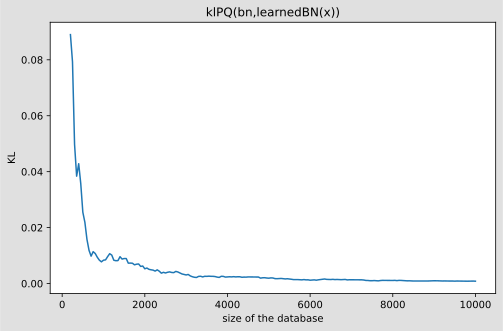

In [21]:
res=[]
for i in range(200,10001,50):
    ParametersLearning(bn2,df[:i])
    g1=gum.ExactBNdistance(bn,bn2)
    res.append(g1.compute()['klPQ'])
fig=figure(figsize=(8,5))
plt.plot(range(200,10001,50),res)
plt.xlabel("size of the database")
plt.ylabel("KL")
plt.title("klPQ(bn,learnedBN(x))")